**Will it rain or won't it rain? I gotta know so I know how to dress!!**

In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns",100)
pd.set_option("display.max_rows",120)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
params={"figure.facecolor":(0.0,0.0,0.0,0),
        "axes.facecolor":(1.0,1.0,1.0,1),
        "savefig.facecolor":(0.0,0.0,0.0,0)}
plt.rcParams.update(params)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,roc_auc_score,roc_curve,confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv("../input/weather-dataset-rattle-package/weatherAUS.csv")
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


Let's check our data:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

There are 142193 readings and 23 columns, of which *RainTomorrow* is our target variable. We also have a mixture of numerical and categorical variables, and some missing values (which we shall tackle when we split the data into the training and testing sets).

First let's see view our target variable ***RainTomorrow***:

In [4]:
df["RainTomorrow"].value_counts()

No     110316
Yes     31877
Name: RainTomorrow, dtype: int64

Text(0, 0.5, 'Count')

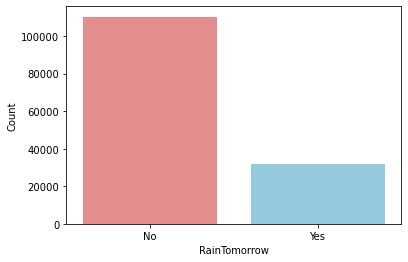

In [5]:
sns.countplot(df["RainTomorrow"],palette=["lightcoral","skyblue"])
plt.ylabel("Count")

In [6]:
df["RainTomorrow"]=df["RainTomorrow"].apply(lambda x:0 if x=="No" else 1)

Now let's go through and check the values for each feature. We will start with the numerical features:

In [7]:
df.describe().drop(["RainTomorrow"],axis=1).T

,count,mean,std,min,25%,50%,75%,max
MinTemp,143975.0,12.194034,6.398495,-8.5,7.6,12.0,16.9,33.9
MaxTemp,144199.0,23.221348,7.119049,-4.8,17.9,22.6,28.2,48.1
Rainfall,142199.0,2.360918,8.478060,0.0,0.0,0.0,0.8,371.0
Evaporation,82670.0,5.468232,4.193704,0.0,2.6,4.8,7.4,145.0
Sunshine,75625.0,7.611178,3.785483,0.0,4.8,8.4,10.6,14.5
WindGustSpeed,135197.0,40.035230,13.607062,6.0,31.0,39.0,48.0,135.0
WindSpeed9am,143693.0,14.043426,8.915375,0.0,7.0,13.0,19.0,130.0
WindSpeed3pm,142398.0,18.662657,8.809800,0.0,13.0,19.0,24.0,87.0
Humidity9am,142806.0,68.880831,19.029164,0.0,57.0,70.0,83.0,100.0
Humidity3pm,140953.0,51.539116,20.795902,0.0,37.0,52.0,66.0,100.0


In [8]:
for column in df.select_dtypes(exclude="object").drop(["RainTomorrow"],axis=1).columns:
    print(column,":",df[column].isnull().sum(),"missing values.")

MinTemp : 1485 missing values.
MaxTemp : 1261 missing values.
Rainfall : 3261 missing values.
Evaporation : 62790 missing values.
Sunshine : 69835 missing values.
WindGustSpeed : 10263 missing values.
WindSpeed9am : 1767 missing values.
WindSpeed3pm : 3062 missing values.
Humidity9am : 2654 missing values.
Humidity3pm : 4507 missing values.
Pressure9am : 15065 missing values.
Pressure3pm : 15028 missing values.
Cloud9am : 55888 missing values.
Cloud3pm : 59358 missing values.
Temp9am : 1767 missing values.
Temp3pm : 3609 missing values.


Quite a number of missing values, which we will impute after we split the data.

For numerical features, it is important to remove any outliers to improve model's performance.

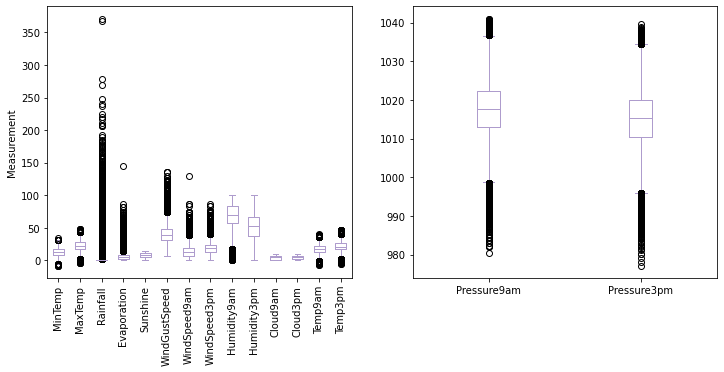

In [9]:
fig,axes=plt.subplots(1,2,figsize=(12,5))

df[df.select_dtypes(exclude="object").columns.drop(["Pressure9am","Pressure3pm","RainTomorrow"])].plot(kind="box",color="#AE9CCD",ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation=90)
axes[0].set_ylabel("Measurement")

df[["Pressure9am","Pressure3pm"]].plot(kind="box",color="#AE9CCD",ax=axes[1])

From the above boxplots, we have quite a number of outliers outside 1.5 times the interquartile range. But because there are no real bounds for weather data, i.e. due to extreme weather events, we will not be removing all of these outliers. If we do we will be creating a perfect dataset that won't properly reflect real world weather. Instead let's just further examine the outliers of the outliers in *Rainfall*, *Evaporation* and *WindSpeed9am*:

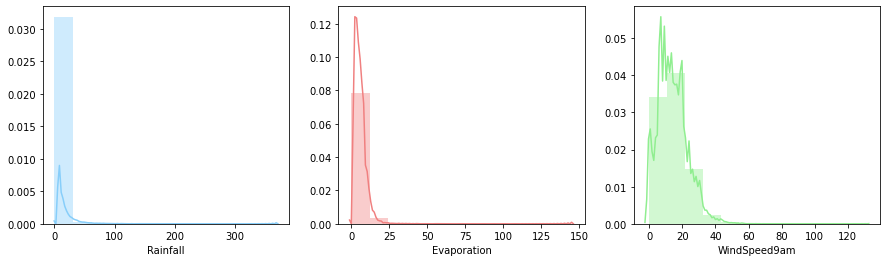

In [10]:
fig,axes=plt.subplots(1,3,figsize=(15,4))

sns.distplot(df["Rainfall"],bins=12,color="lightskyblue",ax=axes[0])
sns.distplot(df["Evaporation"],bins=12,color="lightcoral",ax=axes[1])
sns.distplot(df["WindSpeed9am"],bins=12,color="lightgreen",ax=axes[2])

Although it is possible to achieve these amounts of rainfall, evaporation and wind speed - for example in a storm or heatwave event - we remove them from the dataset so the model doesn't think these extreme weather events are common.

In [11]:
droppers=df.loc[(df["Rainfall"]>300)|(df["Evaporation"]>100)|(df["WindSpeed9am"]>100)]
df.drop(droppers.index,inplace=True)

In [12]:
print("We have dropped {num1} rows, so now instead of the initial 142193 readings, we have {num2}.".format(num1=142193-df.shape[0],num2=df.shape[0]))

We have dropped -3263 rows, so now instead of the initial 142193 readings, we have 145456.


Let's continue with the categorical features:

In [13]:
df.select_dtypes(include="object").describe()

,Date,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday
count,145456,145456,135133,134891,141229,142195
unique,3436,49,16,16,16,2
top,2016-12-02,Canberra,W,N,SE,No
freq,49,3436,9915,11758,10838,110318


For categorical features, it is important to check the actual categories and change the format into numbers. Remember we will only impute the missing data after we split the data.

***Date***

- There are 3436 unique values in the format of YYYY-MM-DD. Instead of using the *categoricals* function, we will just split up the date format into year, month and day but we only use the month data as rain is seasonal and not yearly/daily.

In [14]:
print("{num} missing values.".format(num=df["Date"].isnull().sum()))

0 missing values.


In [15]:
df["Date"]=pd.to_datetime(df["Date"])

In [16]:
df["Month"]=df["Date"].dt.month

- Now we can drop the *Date* column:

In [17]:
df.drop(["Date"],axis=1,inplace=True)
df.head(2)

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month
0,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0,12
1,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0,12


***Location***

- We will not be dropping *Location* because rain is regional.

In [18]:
print("{num} missing values.".format(num=df["Location"].isnull().sum()))

0 missing values.


In [19]:
df["Location"].value_counts()

Canberra            3436
Sydney              3344
Hobart              3193
Brisbane            3193
Perth               3193
Melbourne           3193
Adelaide            3193
Darwin              3192
Townsville          3040
Wollongong          3040
Albury              3040
Albany              3040
Ballarat            3040
AliceSprings        3040
MountGambier        3040
Cairns              3040
GoldCoast           3040
MountGinini         3040
Launceston          3040
Bendigo             3040
Penrith             3039
Tuggeranong         3039
Newcastle           3038
NorfolkIsland       3009
Dartmoor            3009
Portland            3009
Moree               3009
Nuriootpa           3009
SydneyAirport       3009
Witchcliffe         3009
WaggaWagga          3009
Woomera             3009
MelbourneAirport    3009
BadgerysCreek       3009
Richmond            3009
Sale                3009
Cobar               3009
Watsonia            3009
PerthAirport        3009
Mildura             3009


- We will convert these categories into numbers when we impute the missing values after we split the data.

***WindGustDir***

In [20]:
print("{num} missing values.".format(num=df["WindGustDir"].isnull().sum()))

10323 missing values.


In [21]:
df["WindGustDir"].value_counts()

W      9915
SE     9418
N      9313
SSE    9216
E      9181
S      9168
WSW    9068
SW     8967
SSW    8736
WNW    8252
NW     8122
ENE    8104
ESE    7372
NE     7133
NNW    6620
NNE    6548
Name: WindGustDir, dtype: int64

- We will convert these categories into numbers when we impute the missing values after we split the data.

***WindDir9am***

In [22]:
print("{num} missing values.".format(num=df["WindDir9am"].isnull().sum()))

10565 missing values.


In [23]:
df["WindDir9am"].value_counts()

N      11758
SE      9287
E       9176
SSE     9111
NW      8748
S       8659
W       8459
SW      8422
NNE     8129
NNW     7980
ENE     7836
NE      7671
ESE     7630
SSW     7587
WNW     7414
WSW     7024
Name: WindDir9am, dtype: int64

- We will convert these categories into numbers when we impute the missing values after we split the data.

***WindDir3pm***

In [24]:
print("{num} missing values.".format(num=df["WindDir3pm"].isnull().sum()))

4227 missing values.


In [25]:
df["WindDir3pm"].value_counts()

SE     10838
W      10110
S       9925
WSW     9517
SSE     9399
SW      9354
N       8890
WNW     8874
NW      8610
ESE     8505
E       8471
NE      8263
SSW     8156
NNW     7870
ENE     7857
NNE     6590
Name: WindDir3pm, dtype: int64

- We will convert these categories into numbers when we impute the missing values after we split the data.

***RainToday***

In [26]:
print("{num} missing values.".format(num=df["RainToday"].isnull().sum()))

3261 missing values.


In [27]:
df["RainToday"].value_counts()

No     110318
Yes     31877
Name: RainToday, dtype: int64

- We will also convert these text data into numbers but just using a simple if statement:

In [28]:
df["RainToday"]=df["RainToday"].apply(lambda x:0 if x=="No" else 1)
df.head(2)

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month
0,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,0,0,12
1,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,0,0,12


So this is what our data looks like now:

In [29]:
df.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month
0,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,0,0,12
1,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,0,0,12
2,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,0,0,12
3,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,0,0,12
4,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0,12


Before we tackle the missing values or scale the data, we must first split the data into the training and testing sets to ensure we do not cause any data leakage.

In [30]:
x=df.drop(["RainTomorrow"],axis=1)
y=df["RainTomorrow"]

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.33,random_state=7)

In [31]:
print("Training set shape:",x_train.shape)
print("Testing set shape:",x_test.shape)

Training set shape: (97455, 22)
Testing set shape: (48001, 22)


To replace the missing values, we will compute a fill value for the numerical and categorical features based on the training set and then apply them to the testing set.

In [32]:
x_train.isnull().sum()

Location             0
MinTemp           1021
MaxTemp            858
Rainfall          2240
Evaporation      42152
Sunshine         46859
WindGustDir       6886
WindGustSpeed     6840
WindDir9am        7125
WindDir3pm        2853
WindSpeed9am      1205
WindSpeed3pm      2078
Humidity9am       1807
Humidity3pm       3068
Pressure9am      10159
Pressure3pm      10114
Cloud9am         37423
Cloud3pm         39753
Temp9am           1209
Temp3pm           2462
RainToday            0
Month                0
dtype: int64

In [33]:
x_test.isnull().sum()

Location             0
MinTemp            464
MaxTemp            403
Rainfall          1021
Evaporation      20635
Sunshine         22974
WindGustDir       3437
WindGustSpeed     3420
WindDir9am        3440
WindDir3pm        1374
WindSpeed9am       561
WindSpeed3pm       983
Humidity9am        847
Humidity3pm       1438
Pressure9am       4905
Pressure3pm       4913
Cloud9am         18465
Cloud3pm         19604
Temp9am            558
Temp3pm           1146
RainToday            0
Month                0
dtype: int64

Missing values in numerical features will be filled with the median. We could in fact use the mean or a set constant instead, but because of the range and the number of outliers in the data we will use the median.

In [34]:
for df in [x_train,x_test]:
    for col in df.select_dtypes(exclude="object").columns:
        col_median=x_train[col].median()
        df[col].fillna(col_median,inplace=True)

In [35]:
x_train.isnull().sum()

Location            0
MinTemp             0
MaxTemp             0
Rainfall            0
Evaporation         0
Sunshine            0
WindGustDir      6886
WindGustSpeed       0
WindDir9am       7125
WindDir3pm       2853
WindSpeed9am        0
WindSpeed3pm        0
Humidity9am         0
Humidity3pm         0
Pressure9am         0
Pressure3pm         0
Cloud9am            0
Cloud3pm            0
Temp9am             0
Temp3pm             0
RainToday           0
Month               0
dtype: int64

In [36]:
x_test.isnull().sum()

Location            0
MinTemp             0
MaxTemp             0
Rainfall            0
Evaporation         0
Sunshine            0
WindGustDir      3437
WindGustSpeed       0
WindDir9am       3440
WindDir3pm       1374
WindSpeed9am        0
WindSpeed3pm        0
Humidity9am         0
Humidity3pm         0
Pressure9am         0
Pressure3pm         0
Cloud9am            0
Cloud3pm            0
Temp9am             0
Temp3pm             0
RainToday           0
Month               0
dtype: int64

Missing values in categorical features will be filled with the mode.

In [37]:
for df in [x_train,x_test]:
    for col in df.select_dtypes("object").columns:
        col_mode=x_train[col].mode()[0]
        df[col].fillna(col_mode,inplace=True)

In [38]:
x_train.isnull().sum()

Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
Month            0
dtype: int64

In [39]:
x_test.isnull().sum()

Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
Month            0
dtype: int64

Up until now the categorical features are still in text format. We will have to convert them into a format the model will be able to use as input (i.e. numbers). We shall do so by converting the text into numbers using pd.get_dummies, concatenating the dummies to the dataframe, and then dropping the original text column:

In [40]:
for col in x_train.select_dtypes("object").columns:
    x_train=pd.concat([x_train,pd.get_dummies(x_train[col],drop_first=True)],axis=1)
    x_train.drop([col],axis=1,inplace=True)

In [41]:
x_train.head(2)

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,Month,Albany,Albury,AliceSprings,BadgerysCreek,Ballarat,Bendigo,Brisbane,Cairns,Canberra,Cobar,CoffsHarbour,Dartmoor,Darwin,GoldCoast,Hobart,Katherine,Launceston,Melbourne,MelbourneAirport,Mildura,Moree,MountGambier,MountGinini,Newcastle,Nhil,NorahHead,NorfolkIsland,Nuriootpa,PearceRAAF,Penrith,Perth,PerthAirport,...,Watsonia,Williamtown,Witchcliffe,Wollongong,Woomera,ENE,ESE,N,NE,NNE,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW,ENE,ESE,N,NE,NNE,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW,ENE,ESE,N,NE,NNE,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
117374,13.2,21.1,0.2,4.8,8.6,61.0,31.0,31.0,72.0,52.0,1012.3,1010.9,6.0,1.0,19.1,19.8,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
137386,2.1,26.8,0.0,6.6,10.6,26.0,0.0,9.0,34.0,10.0,1024.6,1019.7,0.0,5.0,13.9,25.9,0,8,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [42]:
for col in x_test.select_dtypes("object").columns:
    x_test=pd.concat([x_test,pd.get_dummies(x_test[col],drop_first=True)],axis=1)
    x_test.drop([col],axis=1,inplace=True)

In [43]:
x_test.head(2)

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,Month,Albany,Albury,AliceSprings,BadgerysCreek,Ballarat,Bendigo,Brisbane,Cairns,Canberra,Cobar,CoffsHarbour,Dartmoor,Darwin,GoldCoast,Hobart,Katherine,Launceston,Melbourne,MelbourneAirport,Mildura,Moree,MountGambier,MountGinini,Newcastle,Nhil,NorahHead,NorfolkIsland,Nuriootpa,PearceRAAF,Penrith,Perth,PerthAirport,...,Watsonia,Williamtown,Witchcliffe,Wollongong,Woomera,ENE,ESE,N,NE,NNE,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW,ENE,ESE,N,NE,NNE,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW,ENE,ESE,N,NE,NNE,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
141966,21.5,31.9,0.0,6.6,10.9,31.0,7.0,19.0,71.0,50.0,1013.4,1009.4,1.0,2.0,26.3,30.9,0,7,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
45581,12.7,18.0,0.0,4.8,8.5,30.0,11.0,7.0,72.0,66.0,1028.8,1024.9,7.0,5.0,15.1,16.6,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


Since each feature has it's own range of values, we will scale the data (again, only based on the training set and then applied to the testing set):

In [44]:
scaler=StandardScaler()

x_train=pd.DataFrame(scaler.fit_transform(x_train),columns=x_train.columns)
x_test=pd.DataFrame(scaler.transform(x_test),columns=x_test.columns)

In [45]:
x_train.head(2)

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,Month,Albany,Albury,AliceSprings,BadgerysCreek,Ballarat,Bendigo,Brisbane,Cairns,Canberra,Cobar,CoffsHarbour,Dartmoor,Darwin,GoldCoast,Hobart,Katherine,Launceston,Melbourne,MelbourneAirport,Mildura,Moree,MountGambier,MountGinini,Newcastle,Nhil,NorahHead,NorfolkIsland,Nuriootpa,PearceRAAF,Penrith,Perth,PerthAirport,...,Watsonia,Williamtown,Witchcliffe,Wollongong,Woomera,ENE,ESE,N,NE,NNE,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW,ENE,ESE,N,NE,NNE,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW,ENE,ESE,N,NE,NNE,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
0,0.159913,-0.297879,-0.252120,-0.122719,0.200969,1.595745,1.917315,1.411101,0.163618,0.022137,-0.791268,-0.650879,0.587090,-1.757720,0.329094,-0.272418,-0.564493,1.050839,-0.14695,-0.147314,-0.146622,-0.144675,-0.145229,-0.148546,-0.14905,-0.146366,-0.155678,-0.145044,-0.144379,-0.14556,-0.150268,-0.144157,-0.148293,-0.103201,-0.147641,-0.149266,-0.145743,-0.146403,-0.143376,-0.146403,-0.146257,-0.145817,-0.104363,-0.14486,-0.145155,-0.144083,6.847586,-0.147967,-0.149696,-0.144527,...,-0.14578,-0.144416,-0.143897,-0.147641,-0.147895,-0.243786,-0.230461,-0.262246,-0.225102,-0.215161,-0.218327,-0.242437,-0.258675,-0.262648,-0.260948,-0.251948,-0.258404,2.485654,-0.246491,-0.258471,-0.238209,-0.235382,-0.425072,-0.235163,-0.242484,-0.242579,-0.25181,-0.252248,-0.261351,-0.25768,-0.234531,-0.24745,4.014772,-0.233311,-0.224826,-0.236907,-0.248662,-0.256659,-0.245764,-0.215891,-0.239984,-0.250587,-0.269721,-0.339316,-0.264052,-0.244635,-0.26325,-0.272795,3.913556,-0.264274
1,-1.581882,0.505470,-0.276108,0.444070,0.924900,-1.060613,-1.581648,-1.111200,-1.849658,-2.030122,1.033411,0.668475,-2.039633,0.138671,-0.476571,0.617660,-0.564493,0.467525,-0.14695,-0.147314,6.820253,-0.144675,-0.145229,-0.148546,-0.14905,-0.146366,-0.155678,-0.145044,-0.144379,-0.14556,-0.150268,-0.144157,-0.148293,-0.103201,-0.147641,-0.149266,-0.145743,-0.146403,-0.143376,-0.146403,-0.146257,-0.145817,-0.104363,-0.14486,-0.145155,-0.144083,-0.146037,-0.147967,-0.149696,-0.144527,...,-0.14578,-0.144416,-0.143897,-0.147641,-0.147895,-0.243786,-0.230461,3.813212,-0.225102,-0.215161,-0.218327,-0.242437,-0.258675,-0.262648,-0.260948,-0.251948,-0.258404,-0.402309,-0.246491,-0.258471,-0.238209,-0.235382,2.352544,-0.235163,-0.242484,-0.242579,-0.25181,-0.252248,-0.261351,-0.25768,-0.234531,-0.24745,-0.249080,-0.233311,-0.224826,-0.236907,-0.248662,-0.256659,-0.245764,-0.215891,-0.239984,-0.250587,-0.269721,-0.339316,-0.264052,-0.244635,-0.26325,-0.272795,-0.255522,3.783952


In [46]:
x_test.head(2)

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,Month,Albany,Albury,AliceSprings,BadgerysCreek,Ballarat,Bendigo,Brisbane,Cairns,Canberra,Cobar,CoffsHarbour,Dartmoor,Darwin,GoldCoast,Hobart,Katherine,Launceston,Melbourne,MelbourneAirport,Mildura,Moree,MountGambier,MountGinini,Newcastle,Nhil,NorahHead,NorfolkIsland,Nuriootpa,PearceRAAF,Penrith,Perth,PerthAirport,...,Watsonia,Williamtown,Witchcliffe,Wollongong,Woomera,ENE,ESE,N,NE,NNE,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW,ENE,ESE,N,NE,NNE,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW,ENE,ESE,N,NE,NNE,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
0,1.462336,1.224256,-0.276108,0.444070,1.033490,-0.681134,-0.791559,0.0353,0.110637,-0.075590,-0.628085,-0.875769,-1.601846,-1.283622,1.444629,1.347232,-0.564493,0.175868,-0.14695,-0.147314,-0.146622,-0.144675,-0.145229,-0.148546,-0.14905,-0.146366,-0.155678,-0.145044,-0.144379,-0.14556,6.654756,-0.144157,-0.148293,-0.103201,-0.147641,-0.149266,-0.145743,-0.146403,-0.143376,-0.146403,-0.146257,-0.145817,-0.104363,-0.14486,-0.145155,-0.144083,-0.146037,-0.147967,-0.149696,-0.144527,...,-0.14578,-0.144416,-0.143897,-0.147641,-0.147895,-0.243786,-0.230461,-0.262246,-0.225102,-0.215161,-0.218327,-0.242437,-0.258675,-0.262648,-0.260948,-0.251948,-0.258404,2.485654,-0.246491,-0.258471,-0.238209,-0.235382,-0.425072,-0.235163,-0.242484,-0.242579,-0.25181,-0.252248,-0.261351,-0.25768,-0.234531,-0.247450,4.014772,-0.233311,-0.224826,-0.236907,-0.248662,-0.256659,-0.245764,-0.215891,-0.239984,3.990632,-0.269721,-0.339316,-0.264052,-0.244635,-0.26325,-0.272795,-0.255522,-0.264274
1,0.081454,-0.734788,-0.276108,-0.122719,0.164772,-0.757030,-0.340080,-1.3405,0.163618,0.706223,1.656472,1.448093,1.024877,0.138671,-0.290648,-0.739345,-0.564493,-0.115789,-0.14695,-0.147314,-0.146622,-0.144675,-0.145229,-0.148546,-0.14905,-0.146366,-0.155678,-0.145044,-0.144379,-0.14556,-0.150268,-0.144157,-0.148293,-0.103201,-0.147641,-0.149266,-0.145743,-0.146403,-0.143376,-0.146403,-0.146257,-0.145817,-0.104363,-0.14486,-0.145155,-0.144083,-0.146037,-0.147967,-0.149696,-0.144527,...,-0.14578,-0.144416,-0.143897,6.773175,-0.147895,-0.243786,-0.230461,-0.262246,-0.225102,-0.215161,-0.218327,4.124786,-0.258675,-0.262648,-0.260948,-0.251948,-0.258404,-0.402309,-0.246491,-0.258471,-0.238209,-0.235382,-0.425072,-0.235163,-0.242484,-0.242579,-0.25181,-0.252248,-0.261351,-0.25768,-0.234531,4.041225,-0.249080,-0.233311,-0.224826,-0.236907,-0.248662,-0.256659,4.068943,-0.215891,-0.239984,-0.250587,-0.269721,-0.339316,-0.264052,-0.244635,-0.26325,-0.272795,-0.255522,-0.264274


But before we fit our model, perhaps we should reduce the number of features selected:

Optimal number of features : 101


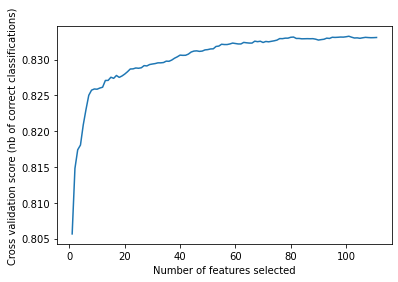

In [47]:
model=LogisticRegression(random_state=7)

min_features_to_select=1
rfecv=RFECV(estimator=model,step=1,cv=5,scoring="accuracy",min_features_to_select=min_features_to_select)
rfecv.fit(x_train,y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(min_features_to_select,
               len(rfecv.grid_scores_)+min_features_to_select),
         rfecv.grid_scores_)
plt.show()

In [48]:
rfetable=pd.DataFrame({"Feature":x_train.columns,"Support":rfecv.support_,"Ranking":rfecv.ranking_,}).sort_values(by="Ranking",ascending=False)
rfetable

,Feature,Support,Ranking
2,Rainfall,False,11
105,SSE,False,10
91,SSW,False,9
70,NNE,False,8
97,ESE,False,7
93,W,False,6
62,Williamtown,False,5
46,PearceRAAF,False,4
66,ENE,False,3
74,SE,False,2


Recurssive feature elimination suggests we can remove some columns to the optimal amount of 101.

In [49]:
x_train=x_train.drop(["Rainfall","SSE","SSW","NNE","ESE","W","Williamtown","PearceRAAF","ENE","SE"],axis=1)
x_test=x_test.drop(["Rainfall","SSE","SSW","NNE","ESE","W","Williamtown","PearceRAAF","ENE","SE"],axis=1)

Now that we have removed some features, we can finally fit our model:

In [50]:
model.fit(x_train,y_train)

LogisticRegression(random_state=7)

In [51]:
parameters=[{"penalty":["l1","l2","elasticnet"]},
            {"C":[0.1,1,10,100]},
            {"class_weight":["balanced",None]},
            {"solver":["newton-cg","lbfgs","liblinear","sag","saga"]},
            {"multi_class":["auto","ovr","multinomial"]}]

grid=GridSearchCV(estimator=model,param_grid=parameters,refit=True,cv=5,verbose=1)

grid.fit(x_train,y_train)

y_predict=grid.predict(x_test)

Fitting 5 folds for each of 17 candidates, totalling 85 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  85 out of  85 | elapsed:  1.5min finished


Next we can evaluate our model using a classifcation report, ROC AUC score, ROC curve  and a confusion matrix:

In [52]:
def cm(predictions):
    cm_matrix=pd.DataFrame(data=confusion_matrix(y_test,predictions),columns=["No Rain","Rain"],index=["No Rain","Rain"])
    sns.heatmap(cm_matrix,annot=True,square=True,fmt="d",cmap="Purples",linecolor="w",linewidth=2)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.yticks(va="center")

In [53]:
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90     36476
           1       0.72      0.51      0.60     11525

    accuracy                           0.84     48001
   macro avg       0.79      0.73      0.75     48001
weighted avg       0.83      0.84      0.83     48001



roc_auc_score:  0.8622138539851122


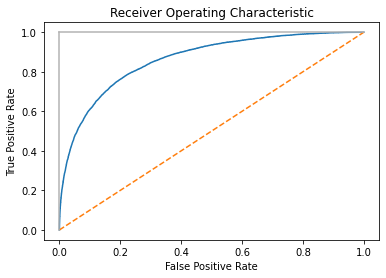

In [54]:
y_score=model.predict_proba(x_test)[:,1]

print("roc_auc_score: ",roc_auc_score(y_test,y_score))

false_positive_rate,true_positive_rate,threshold=roc_curve(y_test,y_score)
plt.plot(false_positive_rate,true_positive_rate)
plt.plot([0,1],ls="--")
plt.plot([0,0],[1,0],c=".7")
plt.plot([1,1],c=".7")
plt.title("Receiver Operating Characteristic")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

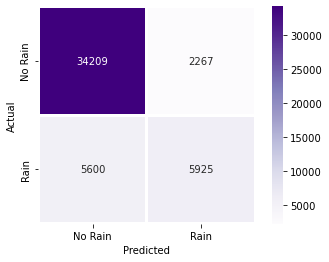

In [55]:
cm(y_predict)

In [56]:
print("Training set score: {num:.4f}.".format(num=model.score(x_train,y_train)))
print("Testing set score: {num:.4f}.".format(num=model.score(x_test,y_test)))

Training set score: 0.8332.
Testing set score: 0.8363.


Our model didn't do so bad with an accuracy score of 0.83 and a ROC AUC score of 0.86! This means our model was able to correctly predict 83% of the instances. It was however better at predicting class 0 (i.e. no rain) than class 1 (i.e. rain) with the higher precision and recall, and the model also predicted a lot more false negatives (i.e. predicted that it would not rain when it actually will) than false positives (i.e. predicted that it would rain when it actually will not). Thankfully after all that work the training and testing scores are very similar so there is no obvious indication of any over/underfitting hence our model will fair well with new data.

**Now should I bring my umbrella or sunglasses..**